# Partial oxidation of Methane over platinum

The following is an exercise in creating a PFR using a series of CSTRs. 

In [9]:
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd
import csv

### Inputs 
specify the inputs for the packed bed reactor
- the Reactor dimensions (radius, length, and catalyst bed area)
- the catalyst properties (surface area to volume ratio) 
- inlet conditions (flowrate, mole fractions)
- solver specifications (number of CSTRs we will use to approximate a PFR, time step size) 


In [10]:
# Inputs 
temp = 600.0           # Temperature in (K)
length = 0.3           # Catalyst bed length (m)
area = 1.0e3           # Catalyst bed area (m^2)
cat_area_per_vol = 10  # Catalyst particle surface area per unit volume (m^2/m^3)
velocity = 0.4         # gas velocity (m/s)
porosity = 0.3         # Catalyst bed porosity (unitless) 

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 201
dt = 1.0

# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol
mass_flow_rate = velocity * gas.density * area

### Create Cantera phases and set initial conditions

greate a gas thermophase using the "methane_pox_on_pt.yaml" example. then, create a surface phase using the following: 
```
surf = ct.Interface(yaml_file, 'Pt_surf', [gas])
```

specify the temperature, pressure, and concentrations for the gas phase. specify the temperature and pressure for the surface phase

In [11]:
# Input file containing the surface reaction mechanism. 
# One of Cantera's out of the box example files
yaml_file = 'methane_pox_on_pt.yaml'

# results file where we will save our data
output_filename = 'surf_pfr_output.csv'

# import the gas model and set the initial conditions
gas = ct.Solution(yaml_file, 'gas')
gas.TPX = temp, ct.one_atm, 'CH4:1, O2:1.5, AR:0.1'

# import the surface model, specifying the gas phase, and also the name for the surface phase
surf = ct.Interface(yaml_file, 'Pt_surf', [gas])
surf.TP = temp, ct.one_atm

### Practical Troubleshooting 
What is often required for the solver to converage properly is a good initial guess of surface coverage. this can be done by advancing the coverages in the first reactor:

In [12]:
# coverage before advancing the coverages
surf()


  Pt_surf:

       temperature   600 K
          pressure   1.0132e+05 Pa
           density   5.3334e-06 kg/m^3
  mean mol. weight   196.08 kg/kmol
   phase of matter   unspecified

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -1.7207e+05        -3.374e+07  J
   internal energy       -1.7207e+05        -3.374e+07  J
           entropy            29.659            5815.5  J/K
    Gibbs function       -1.8986e+05       -3.7229e+07  J
 heat capacity c_p            63.345             12421  J/K
 heat capacity c_v            63.345             12421  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
             PT(S)         0.0099491              0.01           -4.6052
              H(S)           0.99005              0.99           -7.4916
     [   +9 minor]                 0                 0  



In [13]:
# coverage after advancing coverages
surf.advance_coverages(1.0)
surf()


  Pt_surf:

       temperature   600 K
          pressure   1.0132e+05 Pa
           density   5.6971e-06 kg/m^3
  mean mol. weight   209.45 kg/kmol
   phase of matter   unspecified

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        -4.755e+05       -9.9594e+07  J
   internal energy        -4.755e+05       -9.9594e+07  J
           entropy            117.09             24525  J/K
    Gibbs function       -5.4575e+05       -1.1431e+08  J
 heat capacity c_p            83.935             17580  J/K
 heat capacity c_v            83.935             17580  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
             PT(S)           0.14741           0.15827           -1.8435
              H(S)        1.1603e-05        1.2394e-05            -18.78
            H2O(S)         1.199e-05        1.1785e-05     

Alternatively, if one has a guess for the initial coverage, they may specify it similar to how the gas phase mole fractions are specified:

In [17]:
surf.coverages = 'PT(S):0.1'

### Creating a chain of CSTRs to approximate a PFR
The plug flow reactor is represented by a linear chain of zero-dimensional reactors. The gas at the inlet to the first one has the specified inlet composition, and for all others the inlet composition is fixed at the composition of the reactor immediately upstream. Since in a PFR model there is no diffusion, the upstream reactors are not affected by any downstream reactors, and therefore the problem may be solved by simply marching from the first to last reactor, integrating each one to steady state.

<img src="../Images/Chain_of_CSTRs.png"  width="700">

In [8]:
# for our chain of CSTRs approach, we need to determine 
# the differential reactor length 
rlen = length/(NReactors-1)
rvol = area * rlen * porosity

# create a new reactor
r = ct.IdealGasReactor(gas, energy='off')
r.volume = rvol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-9
sim.atol = 1.0e-21

# print columns
print('    distance       X_CH4        X_H2        X_CO')

for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = r.thermo.TDY
    upstream.syncState()
    sim.reinitialize()
    sim.advance_to_steady_state()
    dist = n * rlen * 1.0e3  # distance in mm

    if n % 10 == 0:
        print('  {0:10f}  {1:10f}  {2:10f}  {3:10f}'.format(
            dist, *gas['CH4', 'H2', 'CO'].X))

    # write the gas mole fractions and surface coverages vs. distance
    output_data.append(
        [dist, r.T - 273.15, r.thermo.P/ct.one_atm] + list(gas.X)
        + list(surf.coverages)
    )

with open(output_filename, 'w', newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                    gas.species_names + surf.species_names)
    writer.writerows(output_data)

print("Results saved to '{0}'".format(output_filename))


    distance       X_CH4        X_H2        X_CO
    0.000000    0.096211    0.000187    0.000000
   15.000000    0.096173    0.000180    0.000000
   30.000000    0.096149    0.000175    0.000000
   45.000000    0.096134    0.000172    0.000001
   60.000000    0.096124    0.000170    0.000001
   75.000000    0.096118    0.000169    0.000001
   90.000000    0.096114    0.000168    0.000001
  105.000000    0.096111    0.000167    0.000002
  120.000000    0.096109    0.000167    0.000003
  135.000000    0.096107    0.000167    0.000003
  150.000000    0.096106    0.000167    0.000004
  165.000000    0.096105    0.000167    0.000005
  180.000000    0.096104    0.000167    0.000006
  195.000000    0.096104    0.000167    0.000006
  210.000000    0.096103    0.000166    0.000007
  225.000000    0.096103    0.000166    0.000008
  240.000000    0.096102    0.000166    0.000009
  255.000000    0.096102    0.000166    0.000010
  270.000000    0.096102    0.000166    0.000010
  285.000000    0.09

## Results
plot the resulting surface coverages and concentrations over the length of the PFR. 

In [14]:
# read in the csv to a pandas dataframe
df = pd.read_csv('surf_pfr_output.csv')

<AxesSubplot:xlabel='Distance (mm)'>

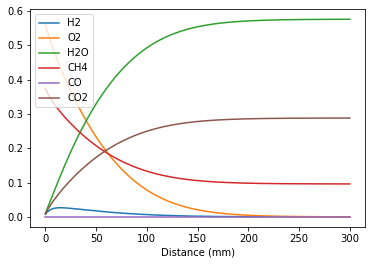

In [15]:
# plot the distance down the reactor vs the mole fractions
df.plot("Distance (mm)", ['H2','O2', 'H2O', 'CH4', 'CO', 'CO2',])